In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
artists=pd.read_csv('../datasets/artists.csv')

G_geo_B_filtered_one = nx.read_gexf('gexf/G_geo_B_filtered_one_mod.gexf')

In [3]:
set([k for n in G_geo_B_filtered_one.nodes for k in G_geo_B_filtered_one.nodes[n].keys()])

{'birth_year',
 'birth_year_order_1_to_N',
 'first_year',
 'label',
 'last_year',
 'movement'}

1. `erdos_renyi_attachment`: This function creates a new node and connects it to each active node in the graph with probability `p`. See how we get p from the given parameters in `link_making_simulation`.

2. `preferential_attachment` and `preferential_attachment_with_1_triangle_closure`: These create a new node and connect it to existing nodes based on degrees, with the latter also ensuring at least one triangle closure.

3. `link_making_simulation`: This decides how many new nodes to add and how many edges to create based on the given parameters, and then calls the appropriate linking function (with correct parameters) to add these nodes and edges to the graph.

4. `tt_model`: This function iterates over each year in the given intervals, decides how many nodes to add and to deactivate based on the given probabilities, and calls `link_making_simulation` to update the graph. Results in a graph that developed over time according to the TT model.


A few things to note:

- The `link_making_simulation` function assumes only three linking functions:  `erdos_renyi_attachment`, `preferential_attachment`, or `preferential_attachment_with_1_triangle_closure`. This may need to be updated.

- The `tt_model` function assumes that the last value in `intervals` is the last year.

- The code does not handle the case where the number of nodes or edges to add is greater than the number of active nodes in the graph. If this can happen, you'll need to adjust the code to handle this case.

- A node can be deactivated the same year it is added.


Intervals:

In [3]:
order_separations =[47, 103, 158, 233, 283, 342,402, 472, 512]

renaissance_intervals=[1390, 1400, 1485, 1498+1]
renaissance_birth_ps = [0.2222, 0.4353, 0.2857]
renaissance_turnoff_ps = [0.0155, 0.01617, 0.01674]
renaissance_node_amounts = [3, 38, 3]
renaissance_edge_amounts = [3, 200, 2]

baroque_intervals=[1554, 1635, 1674+1]
baroque_birth_ps = [0.675, 0.05]
baroque_turnoff_ps = [0.0168, 0.01026]
baroque_node_amounts = [55, 2]
baroque_edge_amounts = [196, 1]

other_intervals=[1675,1789,1839,1857,1870,1885,1919,1950+1] #+1 for iteration
other_turnoff_ps = [0.0146, 0.0153, 0.0152, 0.0154, 0.0159,0.0152, 0.0143]
other_birth_ps = [0.46018, 1.5, 2.77778, 4.53846, 4, 2.05882, 1.28125]
other_node_amounts = [53, 75, 53, 60, 60, 66, 40]
other_edge_amounts = [127, 289, 206, 77, 143, 101, 45]

In [9]:
def erdos_renyi_attachment(G_old, p, new_nodes=1, turn=1):
    G_active = G_old.subgraph([n for n in G_old.nodes if G_old.nodes[n]['status'] == 1])
    G_new = nx.Graph()
    G_new.add_nodes_from(G_old.nodes(data=True))
    G_new.add_edges_from(G_old.edges)
    """if p >= 1:
        #Add all possible edges
        for i in range(new_nodes):
            node_count = G_active.number_of_nodes()
            G_new.add_node(node_count+1)
            #Add attribute status, and turn
            G_new.nodes[node_count+1]['status'] = 1
            G_new.nodes[node_count+1]['turn'] = turn
            #Add edges, only to active nodes
            for n in G_active.nodes:
                if not G_new.has_edge(node_count+1, n):
                    G_new.add_edge(node_count+1, n)
            #Update the active nodes
            G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
        return G_new
    """

    for i in range(new_nodes):
        node_count = G_new.number_of_nodes()
        G_new.add_node(node_count+1)
        #Add attribute status, and turn
        G_new.nodes[node_count+1]['status'] = 1
        G_new.nodes[node_count+1]['turn'] = turn
        #Add edges, only to active nodes
        for n in G_active.nodes:
            if np.random.rand() < p: #If p bigger than 1, all nodes are connected
                if not G_new.has_edge(node_count+1, n):
                    G_new.add_edge(node_count+1, n)
        #Update the active nodes
        G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
    return G_new


def preferential_attachment(G_old, new_edges, new_nodes=1, turn=1):
    G_active = G_old.subgraph([n for n in G_old.nodes if G_old.nodes[n]['status'] == 1])
    G_new = nx.Graph()
    G_new.add_nodes_from(G_old.nodes(data=True))
    G_new.add_edges_from(G_old.edges)
    #If we have too many edges to add, we add all possible edges
    if new_edges >= (len(G_active.nodes)*new_nodes + new_nodes*(new_nodes-1)/2):
        #Add all possible edges
        for i in range(new_nodes):
            node_count = G_active.number_of_nodes()
            G_new.add_node(node_count+1)
            # Add attribute status, and turn
            G_new.nodes[node_count+1]['status'] = 1
            G_new.nodes[node_count+1]['turn'] = turn
            # Add edges, only to active nodes
            if len(G_active.nodes) == 0:
                continue
            for n in G_active.nodes:
                if not G_new.has_edge(node_count+1, n):
                    G_new.add_edge(node_count+1, n)
            #Update the active nodes
            G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
        return G_new
    
    for i in range(new_nodes):
        node_count = G_new.number_of_nodes()
        G_new.add_node(node_count+1)
        # Add attribute status, and turn
        G_new.nodes[node_count+1]['status'] = 1
        G_new.nodes[node_count+1]['turn'] = turn
        # Add edges, only to active nodes
        if len(G_active.nodes) == 0:
            continue
        for j in range(new_edges):
            # Choose a node to connect to
            degrees = np.array([G_active.degree(n) for n in G_active.nodes()])
            degree_sum = np.sum(degrees)
            if degree_sum == 0:
                probabilities = np.ones_like(degrees) / len(degrees)
            else:
                probabilities = degrees / degree_sum
            
            # Normalize probabilities to sum to 1
            #if probabilities.sum() == 0:
                #probabilities = np.ones_like(probabilities) / len(probabilities)
            probabilities = probabilities / probabilities.sum() #Should not be necessary, but just in case
            node_to_connect = np.random.choice(G_active.nodes, p=probabilities)
            if not G_new.has_edge(node_count+1, node_to_connect):
                G_new.add_edge(node_count+1, node_to_connect)
        #Update the active nodes
        G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
    return G_new


def preferential_attachment_with_1_triangle_closure(G_old, new_edges, new_nodes=1, turn=1):
    G_active = G_old.subgraph([n for n in G_old.nodes if G_old.nodes[n]['status'] == 1])
    G_new = nx.Graph()
    G_new.add_nodes_from(G_old.nodes(data=True))
    G_new.add_edges_from(G_old.edges)
    #If we have too many edges to add, we add all possible edges
    if new_edges >= (len(G_active.nodes)*new_nodes + new_nodes*(new_nodes-1)/2):
        #Add all possible edges
        for i in range(new_nodes):
            node_count = G_active.number_of_nodes()
            G_new.add_node(node_count+1)
            # Add attribute status, and turn
            G_new.nodes[node_count+1]['status'] = 1
            G_new.nodes[node_count+1]['turn'] = turn
            # Add edges, only to active nodes
            if len(G_active.nodes) == 0:
                continue
            for n in G_active.nodes:
                if not G_new.has_edge(node_count+1, n):
                    G_new.add_edge(node_count+1, n)
            #Update the active nodes
            G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
        return G_new
    for i in range(new_nodes):
        node_count = G_new.number_of_nodes()
        G_new.add_node(node_count+1)
        # Add attribute status, and turn
        G_new.nodes[node_count+1]['status'] = 1
        G_new.nodes[node_count+1]['turn'] = turn
        # Add edges, only to active nodes
        for j in range(new_edges-1):
            # Choose a node to connect to
            degrees = np.array([G_active.degree(n) for n in G_active.nodes()])
            degree_sum = np.sum(degrees)
            if degree_sum == 0:
                probabilities = np.ones_like(degrees) / len(degrees)
            else:
                probabilities = degrees / degree_sum
            # Normalize probabilities to sum to 1
            probabilities = probabilities / probabilities.sum()
            
            node_to_connect = np.random.choice(G_active.nodes, p=probabilities)
            G_new.add_edge(node_count+1, node_to_connect)
            
        #Update the active nodes
        G_active_and_new = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
        
        #One triangle is closed for each new node
        closed_triangles = 0

        # Create a copy of the nodes and neighbors
        nodes_copy = list(G_active_and_new.nodes)
        neighbors_copy = {node: list(G_active_and_new.neighbors(node)) for node in nodes_copy}
        # Use the copies for iteration
        for node in nodes_copy:
            if (closed_triangles > 0):
                break
            for neighbor in neighbors_copy[node]:
                if (closed_triangles > 0):
                    break
                for neighbor2 in neighbors_copy[neighbor]:
                    if (closed_triangles > 0):
                        break
                    if (neighbor2 != node) and (neighbor2 not in neighbors_copy[node]):
                        G_new.add_edge(node, neighbor2)
                        closed_triangles += 1
                        break
        #Check if not all G_active nodes are connected to the new node
        all_connected = True
        for node in G_active.nodes:
            if (node_count+1 not in G_new.neighbors(node)):
                all_connected = False
                break
        # Calculate probabilities before the if condition
        degrees = np.array([G_active.degree(n) for n in G_active.nodes()])
        degree_sum = np.sum(degrees)
        if degree_sum == 0:
            probabilities = np.ones_like(degrees) / len(degrees)
        else:
            probabilities = degrees / degree_sum

        # Normalize probabilities to sum to 1
        probabilities = probabilities / probabilities.sum()
        
        if (closed_triangles == 0) & (len(G_active_and_new.nodes) > 1) & (not all_connected) & (degree_sum > 0):
            # Choose a node to connect to
            k = 0
            while k < 100:
                node_to_connect = np.random.choice(G_active.nodes, p=probabilities)
                # Check if the edge already exists
                if not G_new.has_edge(node_count+1, node_to_connect):
                    G_new.add_edge(node_count+1, node_to_connect)
                    break
                k += 1
        #Update the active nodes
        G_active = G_new.subgraph([n for n in G_new.nodes if G_new.nodes[n]['status'] == 1])
    return G_new


def link_making_simulation(G, linking_function, new_nodes=1, birth_p=0, turnoff_p=1, node_amount=1, edge_amount=1, interval =1, turn=1):
    G_new = G.copy()
    node_degree_avg=2*edge_amount/node_amount #Theoretical average degree of the nodes
    # Ensure that the 'status' attribute is set for all nodes

    #Amount of times the function is called:
    #We sample a Poisson distribution with mean birth_p, exactly interval times. When the result is higher than 0, we call this function (once)
    #Theoretically, the amount of times this function is called is equal to interval*(1-p_0), where p_0 is the probability of getting 0 from Poisson(birth_p)
    #This equals to interval*(1-exp(-birth_p))
    amount_of_calls = interval*(1-np.exp(-birth_p))
    average_edges_added_per_call = edge_amount/amount_of_calls
    new_edges = np.random.poisson(average_edges_added_per_call)
    if(linking_function == erdos_renyi_attachment):
        #Active nodes number
        active_nodes = [n for n in G_new.nodes if G_new.nodes[n]['status'] == 1]
        if len(active_nodes) == 0:
            p = 0
        else:
            p = new_edges/(len(active_nodes))
        G_new = erdos_renyi_attachment(G_new, p, new_nodes, turn)
    elif(linking_function == preferential_attachment or linking_function == preferential_attachment_with_1_triangle_closure):
        G_new = linking_function(G_new, new_edges, new_nodes, turn)
    else:
        print("No valid linking function")
        return -1
    
    return G_new


def tt_model(linking_function, intervals, birth_ps, turnoff_ps, node_amounts, edge_amounts):
    #First, create a graph with one node
    G = nx.Graph()
    G.add_node(1)
    #Add an attribute to the node: status
    G.nodes[1]['status'] = 1 #1 means active, 0 means inactive
    G.nodes[1]['turn'] = 1 #1 means it was born in the first interval
    first_year = intervals[0]
    last_year = intervals[-1]

    #Iterate over years
    for year in range(first_year+1, last_year+1):
        #0) Gather the birth and turnoff probabilities
        i=0
        while year >= intervals[i+1] and i < len(intervals) - 2: #Assumes intervals are ordered, and the last value is the last year
            i+=1
            

        birth_p = birth_ps[i]
        turnoff_p = turnoff_ps[i]
        node_amount = node_amounts[i]
        edge_amount = edge_amounts[i]
        interval = intervals[i+1] - intervals[i]

        #On average, birth_p nodes are born in a year. This number can higher than 1 (is float)
        #1) Check how many nodes are born this step
        n_born = np.random.poisson(birth_p)
        #2) If any node is born, make the links
        if n_born > 0:
            G = link_making_simulation(G, linking_function, n_born, birth_p, turnoff_p, node_amount, edge_amount, interval ,i)
        #3) Check if any node turns off
        for n in G.nodes: #May change it so newly born nodes are not turned off
            if G.nodes[n]['status'] == 1:
                if np.random.rand() < turnoff_p:
                    G.nodes[n]['status'] = 0
    return G

In [4]:
G_renaissance = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[0]])
G_baroque = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[0] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[1]])
G_rococo = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[1] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[2]])
G_romanticism = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[2] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[3]])
G_realism = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[3] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[4]])
G_impressionism = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[4] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[5]])
G_expressionism = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[5] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[6]])
G_abstract = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[6] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[7]])
G_contemporary = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[7] and G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[8]])
G_other = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] > order_separations[1]])

In [6]:
#Renaissance
print("Renaissance")
print("Original graph: " + str(G_renaissance.number_of_nodes()) + " nodes, " + str(G_renaissance.number_of_edges()) + " edges" + ", average clustering coefficient: " + str(nx.average_clustering(G_renaissance)))

Renaissance
Original graph: 47 nodes, 207 edges, average clustering coefficient: 0.5874883193711238


In [13]:
# Define the models
models = [erdos_renyi_attachment, preferential_attachment, preferential_attachment_with_1_triangle_closure]

# Define the intervals, birth probabilities, turnoff probabilities, node amounts, and edge amounts for each period
renaissance = (renaissance_intervals, renaissance_birth_ps, renaissance_turnoff_ps, renaissance_node_amounts, renaissance_edge_amounts)
baroque = (baroque_intervals, baroque_birth_ps, baroque_turnoff_ps, baroque_node_amounts, baroque_edge_amounts)
other = (other_intervals, other_birth_ps, other_turnoff_ps, other_node_amounts, other_edge_amounts)

# Run the model for each period and each model
erdos_renyi_renaissance = tt_model(erdos_renyi_attachment, *renaissance)

In [72]:
#Number of nodes and edges
print("Number of nodes:", erdos_renyi_renaissance.number_of_nodes())
print("Number of edges:", erdos_renyi_renaissance.number_of_edges())

#Other statistics
degrees = [d for n, d in erdos_renyi_renaissance.degree()]
print("Average degree:", np.mean(degrees))
print("Average clustering coefficient:", nx.average_clustering(erdos_renyi_renaissance))
#Drop the nodes with degree 0
G_r_copy = erdos_renyi_renaissance.copy()
G_r_copy.remove_nodes_from(list(nx.isolates(G_r_copy)))
print("Average shortest path length:", nx.average_shortest_path_length(G_r_copy))
print("Diameter:", nx.diameter(G_r_copy))
print("Average betweenness centrality:", np.mean(list(nx.betweenness_centrality(G_r_copy).values())))

Number of nodes: 42
Number of edges: 212
Average degree: 10.095238095238095
Average clustering coefficient: 0.4270023465567473
Average shortest path length: 1.8506401137980086
Diameter: 4
Average betweenness centrality: 0.023628892049944682


In [83]:
nx.graph_edit_distance(erdos_renyi_renaissance, G_renaissance, timeout=100)


356.0

In [81]:
preferential_renaissance = tt_model(preferential_attachment, *renaissance)

In [85]:
#Number of nodes and edges
print("Number of nodes:", preferential_renaissance.number_of_nodes())
print("Number of edges:", preferential_renaissance.number_of_edges())

#Other statistics
degrees = [d for n, d in preferential_renaissance.degree()]
print("Average degree:", np.mean(degrees))
print("Average clustering coefficient:", nx.average_clustering(preferential_renaissance))
#Drop the nodes with degree 0
G_r_copy = preferential_renaissance.copy()
G_r_copy.remove_nodes_from(list(nx.isolates(G_r_copy)))
print("Average shortest path length:", nx.average_shortest_path_length(G_r_copy))
print("Diameter:", nx.diameter(G_r_copy))
print("Average betweenness centrality:", np.mean(list(nx.betweenness_centrality(G_r_copy).values())))
nx.graph_edit_distance(preferential_renaissance, G_renaissance, timeout=100)

Number of nodes: 47
Number of edges: 215
Average degree: 9.148936170212766
Average clustering coefficient: 0.3168951425653883
Average shortest path length: 1.8837209302325582
Diameter: 3
Average betweenness centrality: 0.02104097452934662


324.0

In [82]:
preferential_triangle_renaissance = tt_model(preferential_attachment_with_1_triangle_closure, *renaissance)

In [86]:
#Number of nodes and edges
print("Number of nodes:", preferential_triangle_renaissance.number_of_nodes())
print("Number of edges:", preferential_triangle_renaissance.number_of_edges())

#Other statistics
degrees = [d for n, d in preferential_triangle_renaissance.degree()]
print("Average degree:", np.mean(degrees))
print("Average clustering coefficient:", nx.average_clustering(preferential_triangle_renaissance))
#Drop the nodes with degree 0
G_r_copy = preferential_triangle_renaissance.copy()
G_r_copy.remove_nodes_from(list(nx.isolates(G_r_copy)))
print("Average shortest path length:", nx.average_shortest_path_length(G_r_copy))
print("Diameter:", nx.diameter(G_r_copy))
print("Average betweenness centrality:", np.mean(list(nx.betweenness_centrality(G_r_copy).values())))
nx.graph_edit_distance(preferential_triangle_renaissance, G_renaissance, timeout=100)

Number of nodes: 51
Number of edges: 242
Average degree: 9.490196078431373
Average clustering coefficient: 0.5704788169401365
Average shortest path length: 1.7855072463768116
Diameter: 3
Average betweenness centrality: 0.01785243741765481


373.0

In [93]:
print("Baroque")
print("Original graph:" + str(G_baroque.number_of_nodes()) + " nodes, " + str(G_baroque.number_of_edges()) + " edges" + ", average clustering coefficient: " + str(nx.average_clustering(G_baroque)))
print("\n")
erdos_renyi_baroque = tt_model(erdos_renyi_attachment, *baroque)
preferential_baroque = tt_model(preferential_attachment, *baroque)
preferential_triangle_baroque = tt_model(preferential_attachment_with_1_triangle_closure, *baroque)

#Number of nodes and edges
print("Number of nodes: ER:", erdos_renyi_baroque.number_of_nodes(), "PA:", preferential_baroque.number_of_nodes(), "PT:", preferential_triangle_baroque.number_of_nodes())
print("Number of edges: ER:", erdos_renyi_baroque.number_of_edges(), "PA:", preferential_baroque.number_of_edges(), "PT:", preferential_triangle_baroque.number_of_edges())
#Other statistics
degrees_ER = [d for n, d in erdos_renyi_baroque.degree()]; degrees_PA = [d for n, d in preferential_baroque.degree()]; degrees_PT = [d for n, d in preferential_triangle_baroque.degree()]
print("Average degree: ER:", np.mean(degrees_ER), "PA:", np.mean(degrees_PA), "PT:", np.mean(degrees_PT))
print("Average clustering coefficient: ER:", nx.average_clustering(erdos_renyi_baroque), "PA:", nx.average_clustering(preferential_baroque), "PT:", nx.average_clustering(preferential_triangle_baroque))
#Drop the nodes with degree 0
G_r_copy = erdos_renyi_baroque.copy(); G_r_copy.remove_nodes_from(list(nx.isolates(G_r_copy))); G_pa_copy = preferential_baroque.copy(); G_pa_copy.remove_nodes_from(list(nx.isolates(G_pa_copy))); G_pt_copy = preferential_triangle_baroque.copy(); G_pt_copy.remove_nodes_from(list(nx.isolates(G_pt_copy)))
print("Average shortest path length: ER:", nx.average_shortest_path_length(G_r_copy), "PA:", nx.average_shortest_path_length(G_pa_copy), "PT:", nx.average_shortest_path_length(G_pt_copy))
print("Diameter: ER:", nx.diameter(G_r_copy), "PA:", nx.diameter(G_pa_copy), "PT:", nx.diameter(G_pt_copy))
print("Average betweenness centrality: ER:", np.mean(list(nx.betweenness_centrality(G_r_copy).values())), "PA:", np.mean(list(nx.betweenness_centrality(G_pa_copy).values())), "PT:", np.mean(list(nx.betweenness_centrality(G_pt_copy).values())))



Baroque
Original graph:56 nodes, 197 edges, average clustering coefficient: 0.680819277645182


Number of nodes: ER: 54 PA: 46 PT: 52
Number of edges: ER: 251 PA: 179 PT: 210
Average degree: ER: 9.296296296296296 PA: 7.782608695652174 PT: 8.076923076923077
Average clustering coefficient: ER: 0.36889213918367686 PA: 0.3411738971571326 PT: 0.613124703423546
Average shortest path length: ER: 2.090497737556561 PA: 2.103030303030303 PT: 1.8138297872340425
Diameter: ER: 4 PA: 5 PT: 2
Average betweenness centrality: ER: 0.02180995475113122 PA: 0.025651867512332636 PT: 0.017691951896392225


In [ ]:
erdos_renyi_other = tt_model(erdos_renyi_attachment, *other)
preferential_other = tt_model(preferential_attachment, *other)
preferential_triangle_other = tt_model(preferential_attachment_with_1_triangle_closure, *other)

In [10]:
#Measure how close the graphs are to the original: nodes, edges, clustering coefficient

def graph_node_edge_cc_distance(G1, G2):
    nodes_distance = abs(G1.number_of_nodes() - G2.number_of_nodes())
    edges_distance = abs(G1.number_of_edges() - G2.number_of_edges())
    cc_distance = abs(nx.average_clustering(G1) - nx.average_clustering(G2))
    #Normalize
    nodes_distance = nodes_distance/G1.number_of_nodes(); edges_distance = edges_distance/G1.number_of_edges(); cc_distance = cc_distance/nx.average_clustering(G1)
    dist = nodes_distance*nodes_distance + edges_distance*edges_distance + cc_distance*cc_distance
    return dist

In [ ]:
#Run Renaissance models 100 times, average nodes, edges and clustering coefficient, and take the top3 closests models to the original graph, then compare to the original graph

ER_nodes = []; PA_nodes = []; PT_nodes = []; ER_edges = []; PA_edges = []; PT_edges = []; ER_clustering = []; PA_clustering = []; PT_clustering = []
ER_top3_models = []; PA_top3_models = []; PT_top3_models = []
for _ in range(100):
    #Run the models
    erdos_renyi_renaissance = tt_model(erdos_renyi_attachment, *renaissance)
    preferential_renaissance = tt_model(preferential_attachment, *renaissance)
    preferential_triangle_renaissance = tt_model(preferential_attachment_with_1_triangle_closure, *renaissance)
    #Number of nodes and edges
    ER_nodes.append(erdos_renyi_renaissance.number_of_nodes()); PA_nodes.append(preferential_renaissance.number_of_nodes()); PT_nodes.append(preferential_triangle_renaissance.number_of_nodes())
    ER_edges.append(erdos_renyi_renaissance.number_of_edges()); PA_edges.append(preferential_renaissance.number_of_edges()); PT_edges.append(preferential_triangle_renaissance.number_of_edges())
    ER_clustering.append(nx.average_clustering(erdos_renyi_renaissance)); PA_clustering.append(nx.average_clustering(preferential_renaissance)); PT_clustering.append(nx.average_clustering(preferential_triangle_renaissance))
    if(_<3):
        ER_top3_models.append(erdos_renyi_renaissance); PA_top3_models.append(preferential_renaissance); PT_top3_models.append(preferential_triangle_renaissance)
    else:
        ER_distance = graph_node_edge_cc_distance(G_renaissance, erdos_renyi_renaissance); PA_distance = graph_node_edge_cc_distance(G_renaissance, preferential_renaissance); PT_distance = graph_node_edge_cc_distance(G_renaissance, preferential_triangle_renaissance)
        # Calculate the distances for the current top 3 models
        ER_distances = [graph_node_edge_cc_distance(G_renaissance, model) for model in ER_top3_models]; PA_distances = [graph_node_edge_cc_distance(G_renaissance, model) for model in PA_top3_models]; PT_distances = [graph_node_edge_cc_distance(G_renaissance, model) for model in PT_top3_models]
        # Find the index of the model with the maximum distance
        ER_max_index = np.argmax(ER_distances);PA_max_index = np.argmax(PA_distances);PT_max_index = np.argmax(PT_distances)

        # Replace the model with the maximum distance if the new model has a smaller distance
        if ER_distance < ER_distances[ER_max_index]:
            ER_top3_models[ER_max_index] = erdos_renyi_renaissance
        if PA_distance < PA_distances[PA_max_index]:
            PA_top3_models[PA_max_index] = preferential_renaissance
        if PT_distance < PT_distances[PT_max_index]:
            PT_top3_models[PT_max_index] = preferential_triangle_renaissance        


In [116]:
m1er_d = nx.graph_edit_distance(G_renaissance, ER_top3_models[0], timeout=100); m2er_d = nx.graph_edit_distance(G_renaissance, ER_top3_models[1], timeout=100); m3er_d = nx.graph_edit_distance(G_renaissance, ER_top3_models[2], timeout=100)
m1pa_d = nx.graph_edit_distance(G_renaissance, PA_top3_models[0], timeout=100); m2pa_d = nx.graph_edit_distance(G_renaissance, PA_top3_models[1], timeout=100); m3pa_d = nx.graph_edit_distance(G_renaissance, PA_top3_models[2], timeout=100)
m1pt_d = nx.graph_edit_distance(G_renaissance, PT_top3_models[0], timeout=100); m2pt_d = nx.graph_edit_distance(G_renaissance, PT_top3_models[1], timeout=100); m3pt_d = nx.graph_edit_distance(G_renaissance, PT_top3_models[2], timeout=100)

#Average nodes, edges and clustering coefficient
print("Average nodes: ER:", np.mean(ER_nodes), "PA:", np.mean(PA_nodes), "PT:", np.mean(PT_nodes))
print("Average edges: ER:", np.mean(ER_edges), "PA:", np.mean(PA_edges), "PT:", np.mean(PT_edges))
print("Average clustering coefficient: ER:", np.mean(ER_clustering), "PA:", np.mean(PA_clustering), "PT:", np.mean(PT_clustering))


Average nodes: ER: 43.26 PA: 36.82 PT: 36.69
Average edges: ER: 232.98 PA: 150.13 PT: 163.15
Average clustering coefficient: ER: 0.44935951320462697 PA: 0.44449275928036003 PT: 0.5855449277445515


In [132]:
#Save these 3 models
nx.write_gexf(ER_top3_models[0], "gexf/generated/ER_top3_models_renaissance_1.gexf")
nx.write_gexf(PA_top3_models[1], "gexf/generated/ER_top3_models_renaissance_2.gexf")
nx.write_gexf(PT_top3_models[0], "gexf/generated/ER_top3_models_renaissance_3.gexf")
print(m1er_d, m2pa_d, m1pt_d)


334.0 309.0 302.0


In [117]:
#Run Baroque models 100 times, average nodes, edges and clustering coefficient, and take the top3 closests models to the original graph, then compare to the original graph

ER_nodes_B = []; PA_nodes_B = []; PT_nodes_B = []; ER_edges_B = []; PA_edges_B = []; PT_edges_B = []; ER_clustering_B = []; PA_clustering_B = []; PT_clustering_B = []
ER_top3_models_B = []; PA_top3_models_B = []; PT_top3_models_B = []

for _ in range(100):
    #Run the models
    erdos_renyi_baroque = tt_model(erdos_renyi_attachment, *baroque)
    preferential_baroque = tt_model(preferential_attachment, *baroque)
    preferential_triangle_baroque = tt_model(preferential_attachment_with_1_triangle_closure, *baroque)
    #Number of nodes and edges
    ER_nodes_B.append(erdos_renyi_baroque.number_of_nodes()); PA_nodes_B.append(preferential_baroque.number_of_nodes()); PT_nodes_B.append(preferential_triangle_baroque.number_of_nodes())
    ER_edges_B.append(erdos_renyi_baroque.number_of_edges()); PA_edges_B.append(preferential_baroque.number_of_edges()); PT_edges_B.append(preferential_triangle_baroque.number_of_edges())
    ER_clustering_B.append(nx.average_clustering(erdos_renyi_baroque)); PA_clustering_B.append(nx.average_clustering(preferential_baroque)); PT_clustering_B.append(nx.average_clustering(preferential_triangle_baroque))
    if(_<3):
        ER_top3_models_B.append(erdos_renyi_baroque); PA_top3_models_B.append(preferential_baroque); PT_top3_models_B.append(preferential_triangle_baroque)
    else:
        #Compare to the original graph
        ER_distance_B = graph_node_edge_cc_distance(G_baroque, erdos_renyi_baroque); PA_distance_B = graph_node_edge_cc_distance(G_baroque, preferential_baroque); PT_distance_B = graph_node_edge_cc_distance(G_baroque, preferential_triangle_baroque)

        # Calculate the distances for the current top 3 models
        ER_distances_B = [graph_node_edge_cc_distance(G_baroque, model) for model in ER_top3_models_B]; PA_distances_B = [graph_node_edge_cc_distance(G_baroque, model) for model in PA_top3_models_B]; PT_distances_B = [graph_node_edge_cc_distance(G_baroque, model) for model in PT_top3_models_B]
        # Find the index of the model with the maximum distance
        ER_max_index_B = np.argmax(ER_distances_B);PA_max_index_B = np.argmax(PA_distances_B);PT_max_index_B = np.argmax(PT_distances_B)

        # Replace the model with the maximum distance if the new model has a smaller distance
        if ER_distance_B < ER_distances_B[ER_max_index_B]:
            ER_top3_models_B[ER_max_index_B] = erdos_renyi_baroque
        if PA_distance_B < PA_distances_B[PA_max_index_B]:
            PA_top3_models_B[PA_max_index_B] = preferential_baroque
        if PT_distance_B < PT_distances_B[PT_max_index_B]:
            PT_top3_models_B[PT_max_index_B] = preferential_triangle_baroque
          

In [118]:
m1er_d_B = nx.graph_edit_distance(G_baroque, ER_top3_models_B[0], timeout=100); m2er_d_B = nx.graph_edit_distance(G_baroque, ER_top3_models_B[1], timeout=100); m3er_d_B = nx.graph_edit_distance(G_baroque, ER_top3_models_B[2], timeout=100)
m1pa_d_B = nx.graph_edit_distance(G_baroque, PA_top3_models_B[0], timeout=100); m2pa_d_B = nx.graph_edit_distance(G_baroque, PA_top3_models_B[1], timeout=100); m3pa_d_B = nx.graph_edit_distance(G_baroque, PA_top3_models_B[2], timeout=100)
m1pt_d_B = nx.graph_edit_distance(G_baroque, PT_top3_models_B[0], timeout=100); m2pt_d_B = nx.graph_edit_distance(G_baroque, PT_top3_models_B[1], timeout=100); m3pt_d_B = nx.graph_edit_distance(G_baroque, PT_top3_models_B[2], timeout=100)

#Average nodes, edges and clustering coefficient
print("Average nodes: ER:", np.mean(ER_nodes_B), "PA:", np.mean(PA_nodes_B), "PT:", np.mean(PT_nodes_B))
print("Average edges: ER:", np.mean(ER_edges_B), "PA:", np.mean(PA_edges_B), "PT:", np.mean(PT_edges_B))
print("Average clustering coefficient: ER:", np.mean(ER_clustering_B), "PA:", np.mean(PA_clustering_B), "PT:", np.mean(PT_clustering_B))



Average nodes: ER: 57.8 PA: 56.25 PT: 55.16
Average edges: ER: 268.03 PA: 208.8 PT: 220.18
Average clustering coefficient: ER: 0.290251705176586 PA: 0.32139631358003357 PT: 0.5595698787402555


In [133]:
print(m3er_d_B, m2pa_d_B, m2pt_d_B)
#Save these 3 models
nx.write_gexf(ER_top3_models_B[2], "gexf/generated/ER_top3_models_baroque_1.gexf")
nx.write_gexf(PA_top3_models_B[1], "gexf/generated/ER_top3_models_baroque_2.gexf")
nx.write_gexf(PT_top3_models_B[1], "gexf/generated/ER_top3_models_baroque_3.gexf")

339.0 288.0 347.0


In [14]:
#Run Other models 100 times, average nodes, edges and clustering coefficient, and take the top3 closests models to the original graph, then compare to the original graph

ER_nodes_O = []; PA_nodes_O = []; PT_nodes_O = []; ER_edges_O = []; PA_edges_O = []; PT_edges_O = []; ER_clustering_O = []; PA_clustering_O = []; PT_clustering_O = []
ER_top3_models_O = []; PA_top3_models_O = []; PT_top3_models_O = []

for _ in range(100):
    if _ % 10 == 0:
        print(_,"%")
    #Run the models
    erdos_renyi_other = tt_model(erdos_renyi_attachment, *other)
    preferential_other = tt_model(preferential_attachment, *other)
    preferential_triangle_other = tt_model(preferential_attachment_with_1_triangle_closure, *other)
    #Number of nodes and edges
    ER_nodes_O.append(erdos_renyi_other.number_of_nodes()); PA_nodes_O.append(preferential_other.number_of_nodes()); PT_nodes_O.append(preferential_triangle_other.number_of_nodes())
    ER_edges_O.append(erdos_renyi_other.number_of_edges()); PA_edges_O.append(preferential_other.number_of_edges()); PT_edges_O.append(preferential_triangle_other.number_of_edges())
    ER_clustering_O.append(nx.average_clustering(erdos_renyi_other)); PA_clustering_O.append(nx.average_clustering(preferential_other)); PT_clustering_O.append(nx.average_clustering(preferential_triangle_other))
    if(_<3):
        ER_top3_models_O.append(erdos_renyi_other); PA_top3_models_O.append(preferential_other); PT_top3_models_O.append(preferential_triangle_other)
    else:
        #Compare to the original graph
        ER_distance_O = graph_node_edge_cc_distance(G_other, erdos_renyi_other); PA_distance_O = graph_node_edge_cc_distance(G_other, preferential_other); PT_distance_O = graph_node_edge_cc_distance(G_other, preferential_triangle_other)

        # Calculate the distances for the current top 3 models
        ER_distances_O = [graph_node_edge_cc_distance(G_other, model) for model in ER_top3_models_O]; PA_distances_O = [graph_node_edge_cc_distance(G_other, model) for model in PA_top3_models_O]; PT_distances_O = [graph_node_edge_cc_distance(G_other, model) for model in PT_top3_models_O]
        # Find the index of the model with the maximum distance
        ER_max_index_O = np.argmax(ER_distances_O);PA_max_index_O = np.argmax(PA_distances_O);PT_max_index_O = np.argmax(PT_distances_O)

        # Replace the model with the maximum distance if the new model has a smaller distance
        if ER_distance_O < ER_distances_O[ER_max_index_O]:
            ER_top3_models_O[ER_max_index_O] = erdos_renyi_other
        if PA_distance_O < PA_distances_O[PA_max_index_O]:
            PA_top3_models_O[PA_max_index_O] = preferential_other
        if PT_distance_O < PT_distances_O[PT_max_index_O]:
            PT_top3_models_O[PT_max_index_O] = preferential_triangle_other


#Average nodes, edges and clustering coefficient
print("Average nodes: ER:", np.mean(ER_nodes_O), "PA:", np.mean(PA_nodes_O), "PT:", np.mean(PT_nodes_O))
print("Average edges: ER:", np.mean(ER_edges_O), "PA:", np.mean(PA_edges_O), "PT:", np.mean(PT_edges_O))
print("Average clustering coefficient: ER:", np.mean(ER_clustering_O), "PA:", np.mean(PA_clustering_O), "PT:", np.mean(PT_clustering_O))

#Top 3 models
print("Average nodes: ER:", np.mean([model.number_of_nodes() for model in ER_top3_models_O]), "PA:", np.mean([model.number_of_nodes() for model in PA_top3_models_O]), "PT:", np.mean([model.number_of_nodes() for model in PT_top3_models_O]))

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Average nodes: ER: 405.45 PA: 406.55 PT: 405.98
Average edges: ER: 2591.72 PA: 2381.75 PT: 2406.06
Average clustering coefficient: ER: 0.09377613261317999 PA: 0.1306099676957868 PT: 0.36673846291148093
Average nodes: ER: 399.3333333333333 PA: 387.6666666666667 PT: 415.3333333333333


In [16]:

print("Average nodes: ER:", np.mean([model.number_of_nodes() for model in ER_top3_models_O]), "PA:", np.mean([model.number_of_nodes() for model in PA_top3_models_O]), "PT:", np.mean([model.number_of_nodes() for model in PT_top3_models_O]))
print("Average edges: ER:", np.mean([model.number_of_edges() for model in ER_top3_models_O]), "PA:", np.mean([model.number_of_edges() for model in PA_top3_models_O]), "PT:", np.mean([model.number_of_edges() for model in PT_top3_models_O]))
print("Average clustering coefficient: ER:", np.mean([nx.average_clustering(model) for model in ER_top3_models_O]), "PA:", np.mean([nx.average_clustering(model) for model in PA_top3_models_O]), "PT:", np.mean([nx.average_clustering(model) for model in PT_top3_models_O]))

Average nodes: ER: 399.3333333333333 PA: 387.6666666666667 PT: 415.3333333333333
Average edges: ER: 2576.6666666666665 PA: 2245.0 PT: 2388.6666666666665
Average clustering coefficient: ER: 0.11147665714962297 PA: 0.15586900467662035 PT: 0.43915549432103446


In [15]:
#G_other statistics
print("Original graph: " + str(G_other.number_of_nodes()) + " nodes, " + str(G_other.number_of_edges()) + " edges" + ", average clustering coefficient: " + str(nx.average_clustering(G_other)))   

Original graph: 409 nodes, 2407 edges, average clustering coefficient: 0.6247247455636262


In [ ]:
#Save all top3 models

nx.write_gexf(ER_top3_models_O[0], "gexf/generated/ER_top3_models_other_1.gexf")
nx.write_gexf(ER_top3_models_O[1], "gexf/generated/ER_top3_models_other_2.gexf")
nx.write_gexf(ER_top3_models_O[2], "gexf/generated/ER_top3_models_other_3.gexf")
nx.write_gexf(PA_top3_models_O[0], "gexf/generated/PA_top3_models_other_1.gexf")
nx.write_gexf(PA_top3_models_O[1], "gexf/generated/PA_top3_models_other_2.gexf")
nx.write_gexf(PA_top3_models_O[2], "gexf/generated/PA_top3_models_other_3.gexf")
nx.write_gexf(PT_top3_models_O[0], "gexf/generated/PT_top3_models_other_1.gexf")
nx.write_gexf(PT_top3_models_O[1], "gexf/generated/PT_top3_models_other_2.gexf")
nx.write_gexf(PT_top3_models_O[2], "gexf/generated/PT_top3_models_other_3.gexf")



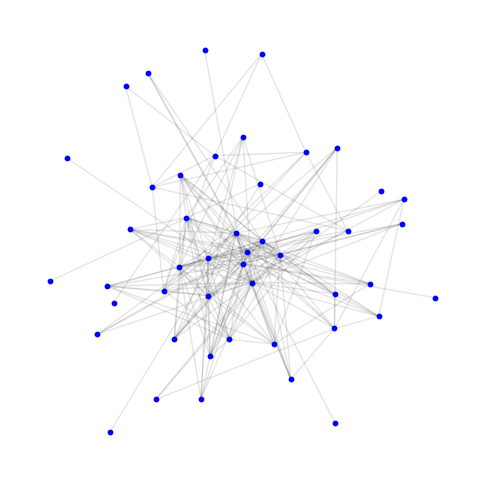

In [16]:
#Renaissance: subgraph of the graph with node attribute 'birth_year_order_1_to_N' less than 48
G_renaissance = G_geo_B_filtered_one.subgraph([n for n in G_geo_B_filtered_one.nodes if G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N'] <= order_separations[0]])
#Plot the renaissance graph
plt.figure(figsize=(6,6))
pos = nx.spring_layout(G_renaissance, k=0.4, iterations=10)
nx.draw_networkx_nodes(G_renaissance, pos, node_size=10, node_color='blue')
nx.draw_networkx_edges(G_renaissance, pos, alpha=0.1)
plt.axis('off')
plt.show()


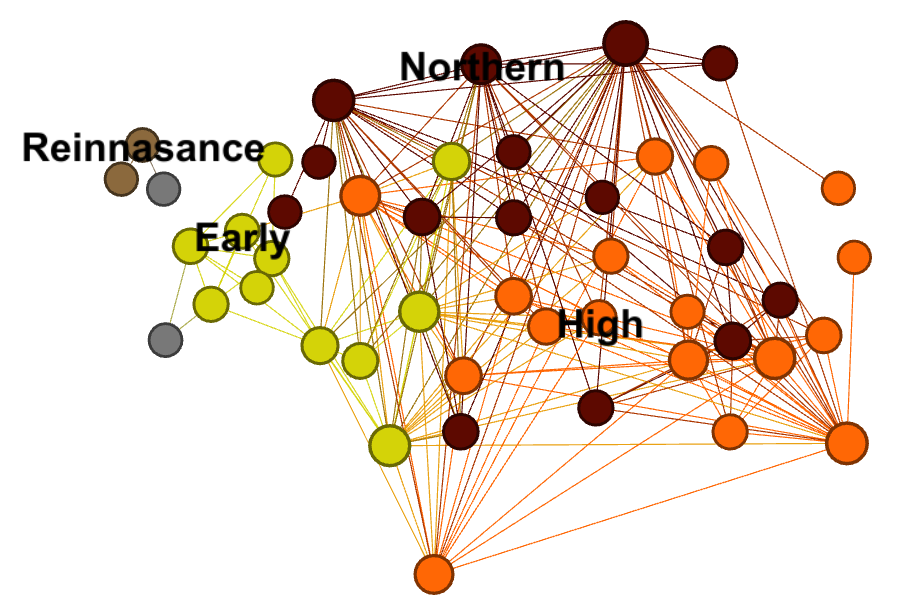

In [ ]:
#See which model fits best for each period. Random graph, preferential attachment, or a combination of both?

#Renaissance
avg_degree = 2*G_renaissance.number_of_edges()/G_renaissance.number_of_nodes()
#1) Random graph
p = avg_degree/(G_renaissance.number_of_nodes()-1)
G_ren_rand = nx.erdos_renyi_graph(G_renaissance.number_of_nodes(), p)

#2) Preferential attachment with triadic closure
m_t = (avg_degree/2)
m = int(m_t)
G_ren_pref = nx.barabasi_albert_graph(G_renaissance.number_of_nodes(), m)

# Create a list of nodes with degree less than m
nodes_with_degree_less_than_m = [n for n in G_ren_pref.nodes if G_ren_pref.degree[n] < m]

# Until we have the right amount of edges, close a triangle
while G_ren_pref.number_of_edges() < G_renaissance.number_of_edges():
    for n in nodes_with_degree_less_than_m:
        neighbors = list(G_ren_pref.neighbors(n))
        for n2 in neighbors:
            if G_ren_pref.degree[n2] < m and not G_ren_pref.has_edge(n, n2):
                G_ren_pref.add_edge(n, n2)
                if G_ren_pref.degree[n] >= m:
                    nodes_with_degree_less_than_m.remove(n)
                if G_ren_pref.degree[n2] >= m:
                    nodes_with_degree_less_than_m.remove(n2)

#3) Preferential attachment with random rewiring, and triadic closure
G_ren_pref_rand = G_ren_pref.copy()
edges_to_rewire = [e for e in G_ren_pref_rand.edges if np.random.rand() < 0.5]
for e in edges_to_rewire:
    G_ren_pref_rand.remove_edge(e[0], e[1])
    G_ren_pref_rand.add_edge(np.random.choice(G_ren_pref_rand.nodes), np.random.choice(G_ren_pref_rand.nodes))


#4) Preferential attachment with random rewiring, and triadic closure, first triadic closure, then random rewiring
#skipped for runtime
#5) Watts-Strogatz
G_ren_watts = nx.watts_strogatz_graph(G_renaissance.number_of_nodes(), m, 0.5)

#6) Watts-Strogatz with triadic closure
G_ren_watts_tri = nx.watts_strogatz_graph(G_renaissance.number_of_nodes(), m, 0.5)
# Create a list of nodes with degree less than m
nodes_with_degree_less_than_m = [n for n in G_ren_watts_tri.nodes if G_ren_watts_tri.degree[n] < m]
while G_ren_watts_tri.number_of_edges() < G_renaissance.number_of_edges():
    for n in nodes_with_degree_less_than_m:
        neighbors = list(G_ren_watts_tri.neighbors(n))
        for n2 in neighbors:
            if G_ren_watts_tri.degree[n2] < m and not G_ren_watts_tri.has_edge(n, n2):
                G_ren_watts_tri.add_edge(n, n2)
                if G_ren_watts_tri.degree[n] >= m:
                    nodes_with_degree_less_than_m.remove(n)
                if G_ren_watts_tri.degree[n2] >= m:
                    nodes_with_degree_less_than_m.remove(n2)



KeyboardInterrupt: 

In [ ]:
#Copilot speedup suggestion
nodes_with_degree_less_than_m = [n for n in G_ren_pref.nodes if G_ren_pref.degree[n] < m]
while G_ren_pref.number_of_edges() < G_renaissance.number_of_edges():
    for n in nodes_with_degree_less_than_m:
        neighbors = list(G_ren_pref.neighbors(n))
        for n2 in neighbors:
            if G_ren_pref.degree[n2] < m and not G_ren_pref.has_edge(n, n2):
                G_ren_pref.add_edge(n, n2)
                if G_ren_pref.degree[n] >= m:
                    nodes_with_degree_less_than_m.remove(n)
                if G_ren_pref.degree[n2] >= m:
                    nodes_with_degree_less_than_m.remove(n2)


In [24]:
print('Random graph:', nx.graph_edit_distance(G_renaissance, G_ren_rand, timeout=100))
print('Preferential attachment with triadic closure:', nx.graph_edit_distance(G_renaissance, G_ren_pref, timeout=100))

Random graph: 297.0
Preferential attachment with triadic closure: 317.0


In [ ]:
print('Preferential attachment with random rewiring, and triadic closure:', nx.graph_edit_distance(G_renaissance, G_ren_pref_rand, timeout=1000))

In [ ]:
#Compare the results with optimize_graph_edit_distance
print('Random graph:', nx.graph_edit_distance(G_renaissance, G_ren_rand, timeout=1000))
print('Preferential attachment with triadic closure:', nx.graph_edit_distance(G_renaissance, G_ren_pref, timeout=1000))
print('Preferential attachment with random rewiring, and triadic closure:', nx.graph_edit_distance(G_renaissance, G_ren_pref_rand, timeout=1000))
print('Preferential attachment with random rewiring, and triadic closure, first triadic closure, then random rewiring:', nx.graph_edit_distance(G_renaissance, G_ren_pref_rand2, timeout=1000))
print('Watts-Strogatz:', nx.graph_edit_distance(G_renaissance, G_ren_watts, timeout=1000))
print('Watts-Strogatz with triadic closure:', nx.graph_edit_distance(G_renaissance, G_ren_watts_tri, timeout=1000))



In [ ]:
#Baroque

avg_degree = 2*G_baroque.number_of_edges()/G_baroque.number_of_nodes()
#1) Random graph
p = avg_degree/(G_baroque.number_of_nodes()-1)
G_bar_rand = nx.erdos_renyi_graph(G_baroque.number_of_nodes(), p)

#2) Preferential attachment with triadic closure
m_t = (avg_degree/2)
m = int(m_t)
G_bar_pref = nx.barabasi_albert_graph(G_baroque.number_of_nodes(), m)
#Until we have the right amount of edges, close a triangle
while G_bar_pref.number_of_edges() < G_baroque.number_of_edges():
    for n in G_bar_pref.nodes:
        if G_bar_pref.degree[n] < m:
            neighbors = list(G_bar_pref.neighbors(n))
            for n2 in neighbors:
                if G_bar_pref.degree[n2] < m and not G_bar_pref.has_edge(n, n2):
                    G_bar_pref.add_edge(n, n2)

#3) Preferential attachment with random rewiring, and triadic closure
G_bar_pref_rand = nx.barabasi_albert_graph(G_baroque.number_of_nodes(), m)
for e in G_bar_pref_rand.edges:
    if np.random.rand() < 0.5:
        G_bar_pref_rand.remove_edge(e[0], e[1])
        G_bar_pref_rand.add_edge(np.random.choice(G_bar_pref_rand.nodes), np.random.choice(G_bar_pref_rand.nodes))

#Until we have the right amount of edges, close a triangle
while G_bar_pref_rand.number_of_edges() < G_baroque.number_of_edges():
    for n in G_bar_pref_rand.nodes:
        if G_bar_pref_rand.degree[n] < m:
            for e in G_bar_pref_rand.edges:
                if n in e:
                    for n2 in e:
                        if n2 != n and G_bar_pref_rand.degree[n2] < m:
                            G_bar_pref_rand.add_edge(n, n2)

#4) Preferential attachment with random rewiring, and triadic closure, first triadic closure, then random rewiring
G_bar_pref_rand2 = nx.barabasi_albert_graph(G_baroque.number_of_nodes(), m)
#Until we have the right amount of edges, close a triangle

while G_bar_pref_rand2.number_of_edges() < G_baroque.number_of_edges():
    for n in G_bar_pref_rand2.nodes:
        if G_bar_pref_rand2.degree[n] < m:
            for e in G_bar_pref_rand2.edges:
                if n in e:
                    for n2 in e:
                        if n2 != n and G_bar_pref_rand2.degree[n2] < m:
                            G_bar_pref_rand2.add_edge(n, n2)
for e in G_bar_pref_rand2.edges:
    if np.random.rand() < 0.5:
        G_bar_pref_rand2.remove_edge(e[0], e[1])
        G_bar_pref_rand2.add_edge(np.random.choice(G_bar_pref_rand2.nodes), np.random.choice(G_bar_pref_rand2.nodes))

#5) Watts-Strogatz
G_bar_watts = nx.watts_strogatz_graph(G_baroque.number_of_nodes(), m, 0.5)

#6) Watts-Strogatz with triadic closure
G_bar_watts_tri = nx.watts_strogatz_graph(G_baroque.number_of_nodes(), m, 0.5)
#Until we have the right amount of edges, close a triangle
while G_bar_watts_tri.number_of_edges() < G_baroque.number_of_edges():
    for n in G_bar_watts_tri.nodes:
        if G_bar_watts_tri.degree[n] < m:
            for e in G_bar_watts_tri.edges:
                if n in e:
                    for n2 in e:
                        if n2 != n and G_bar_watts_tri.degree[n2] < m:
                            G_bar_watts_tri.add_edge(n, n2)